In [0]:
%tensorflow_version 2.x

## step0: 載入資料並觀察

In [0]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
# shape = (資料筆數batch, 圖片高height, 圖片寬width, 通道數channel)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


ans: frog


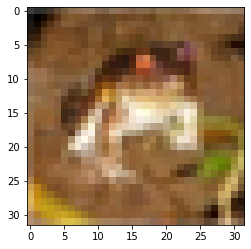

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

names = ["airplane", "automobile", "bird", "cat", "deer",
         "dog", "frog", "horse", "ship", "truck"]

# y_train[0]           = [6]   -> 注意 type(y_train[0])=list，為了以後可以擴充成為多種類分類
# y_train[0][0]        =  6    -> 取出第一筆訓練資料的答案
# names[y_train[0][0]] = frog  -> 將答案名字配對出來

print("ans:", names[y_train[0][0]])
plt.imshow(x_train[0])

In [5]:
# 注意 (32, 32) != (32, 32, 1)  != (32, 32, 3)
# (32, 32)    -> 是 2D
# (32, 32, 1) -> 是 3D

print(x_train[0].shape) # -> (32, 32, 3)
x_train[0]

(32, 32, 3)


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## step1: 資料預處理

### 對題目做 normalize (常態化)
1. CNN 不需要先對資料做 reshape，因為模型在卷積後會 Flatten 成一維 (1D)
2. input 介於 [0, 1] 或 [-1, 1] 較方便設定權值並迭代，故要除 255
3. 除 255，是因為顏色介於 [0, 255]

In [0]:
x_train_norm = x_train / 255
x_test_norm  = x_test / 255

### 不對答案做 one-hot encoding
- 使用 `sparse`：請模型自己對答案做 one-hot encoding，以節省記憶體

## step2: 訓練模型

### 建立模型：Sequential
- CNN
  1. Convolution 卷積：  
     目的：對影像進行**特徵萃取/過濾**，以得到有用的(想要的)資訊  
     方法：改變影像通道數 (channel)  
  ```
     Conv2D(filters=64,              # 過濾出 64 個特徵
            kernel_size=(3, 3),      # 濾鏡的大小 (濾鏡 = filter = kernel map)
            strides=1,               # 濾鏡移動的步伐大小
            padding='same',          # 為了不改變影像尺寸，在影像外圍加白邊 (zero padding)
            activation="relu",       # 激活函數(非線性轉換)
            input_shape=(32, 32, 3)  # 輸入影像的維度 = (height, width, channel)
            )
  ```  
  2. Pooling 池化：  
     目的：減少影像資料量與計算量，並保留重要資訊  
     方法：改變影像高寬 (height, width)  
     例如：MaxPooling、AveragePooling

  3. 進階作法：`Conv2D(kernel_size=(4, 4), strides=2, ...)`  
     當設定 `strides=2` 時，表示卷積和池化一起執行了；  
     但為了讓每個像素都有平均被使用，因此必須保證 `kernel_size` % `strides` = 0 

- MLP
  1. Flatten：將影像轉換成一維陣列 (1D Array)
  2. Dense：全連階層
  3. Dropout：隨機丟棄神經元


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

model = Sequential()

# simple_VGG-16
# 第一次卷積和池化
model.add(Conv2D(64, (3, 3), padding='same', activation="relu", input_shape=(32, 32, 3)))
model.add(MaxPooling2D())
# 第二次卷積和池化
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D())
# 第三次卷積和池化
model.add(Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))  
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

#### **Parameter numbers**
$ \text{CNN Parameter numbers}  = (height_{kernel} \times width_{kernel}) \times channel_{feature} \times filters + bias_{filters} $ 
- 第一次卷積：$ \text{Param} = (3 \times 3) \times 3 \times 64 \times + 64 = 1792 $  
- 第二次卷積：$ \text{Param} = (3 \times 3) \times 64 \times 128 \times + 128 = 73856 $  
- 第三次卷積：$ \text{Param} = (3 \times 3) \times 128 \times 256 \times + 256 = 295168 $

> bias：每一個 filters 都有一個 activation，所以有多少個 filters，就會有多少個 bias

$ \text{MLP Parameter numbers}  = input \times output_{units} + bias_{output} $ 
- 展平成一維：$ \text{Shape} = 4 \times 4 \times 256 = 4096 $    
- 中間層：$ \text{Param} = 4096 \times 128 + 128 = 524416 $  
- 最終層：$ \text{Param} = 128 \times 10 + 10 = 1290 $  

### 確定模型訓練方式
- `sparse`：請模型自己對答案做 one-hot encoding，以節省記憶體

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
              optimizer="adam", 
              metrics=["accuracy"])

### 訓練模型

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

stop_callback = EarlyStopping(patience=3, restore_best_weights=True)
save_callback = ModelCheckpoint("cifar10.h5", save_best_only=True)

model.fit(x_train_norm, 
          y_train,
          batch_size=200,
          epochs=100,
          callbacks=[stop_callback, save_callback], 
          validation_split=0.1,
          verbose=2)

Epoch 1/100
225/225 - 3s - loss: 1.6651 - accuracy: 0.3892 - val_loss: 1.3070 - val_accuracy: 0.5242
Epoch 2/100
225/225 - 2s - loss: 1.2386 - accuracy: 0.5588 - val_loss: 1.0657 - val_accuracy: 0.6222
Epoch 3/100
225/225 - 3s - loss: 1.0441 - accuracy: 0.6324 - val_loss: 0.9586 - val_accuracy: 0.6670
Epoch 4/100
225/225 - 3s - loss: 0.9067 - accuracy: 0.6829 - val_loss: 0.8736 - val_accuracy: 0.7000
Epoch 5/100
225/225 - 2s - loss: 0.8151 - accuracy: 0.7149 - val_loss: 0.7682 - val_accuracy: 0.7358
Epoch 6/100
225/225 - 3s - loss: 0.7419 - accuracy: 0.7420 - val_loss: 0.7189 - val_accuracy: 0.7486
Epoch 7/100
225/225 - 2s - loss: 0.6707 - accuracy: 0.7665 - val_loss: 0.7746 - val_accuracy: 0.7346
Epoch 8/100
225/225 - 3s - loss: 0.6177 - accuracy: 0.7829 - val_loss: 0.6795 - val_accuracy: 0.7674
Epoch 9/100
225/225 - 2s - loss: 0.5579 - accuracy: 0.8036 - val_loss: 0.6842 - val_accuracy: 0.7716
Epoch 10/100
225/225 - 2s - loss: 0.4911 - accuracy: 0.8260 - val_loss: 0.7008 - val_accura

## step3: 預測結果

In [10]:
pre = model.predict_classes(x_test_norm)
print(pre.shape)
pre

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
(10000,)


array([5, 8, 8, ..., 5, 4, 7])

In [11]:
print(y_test.shape)
y_test

(10000, 1)


array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [12]:
y_test_1d = y_test.reshape(-1) # -1 是請 python 幫忙計算
print(y_test_1d.shape)
y_test_1d

(10000,)


array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

## step4: 驗證模型

In [13]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7277 - accuracy: 0.7527


[0.7276795506477356, 0.7526999711990356]

### 分類準確性評估 (混淆矩陣)

In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

c = [f"{i}(預測)" for i in names] 
i = [f"{i}(正確)" for i in names] 
mat = confusion_matrix(y_test, pre)
mat = [row for row in mat]

pd.DataFrame(mat, columns=c, index=i)

,airplane(預測),automobile(預測),bird(預測),cat(預測),deer(預測),dog(預測),frog(預測),horse(預測),ship(預測),truck(預測)
airplane(正確),773,15,30,19,21,9,6,8,93,26
automobile(正確),16,888,3,7,2,3,4,0,29,48
bird(正確),62,6,607,67,94,70,49,18,17,10
cat(正確),17,8,56,580,65,173,48,21,19,13
deer(正確),17,2,54,58,763,25,26,38,14,3
dog(正確),11,1,34,159,49,680,12,34,11,9
frog(正確),3,6,44,68,33,24,805,3,10,4
horse(正確),19,1,31,52,63,68,4,747,4,11
ship(正確),36,20,7,13,11,4,2,0,891,16
truck(正確),28,97,8,18,3,5,4,10,34,793


### 印出預測錯誤的圖像

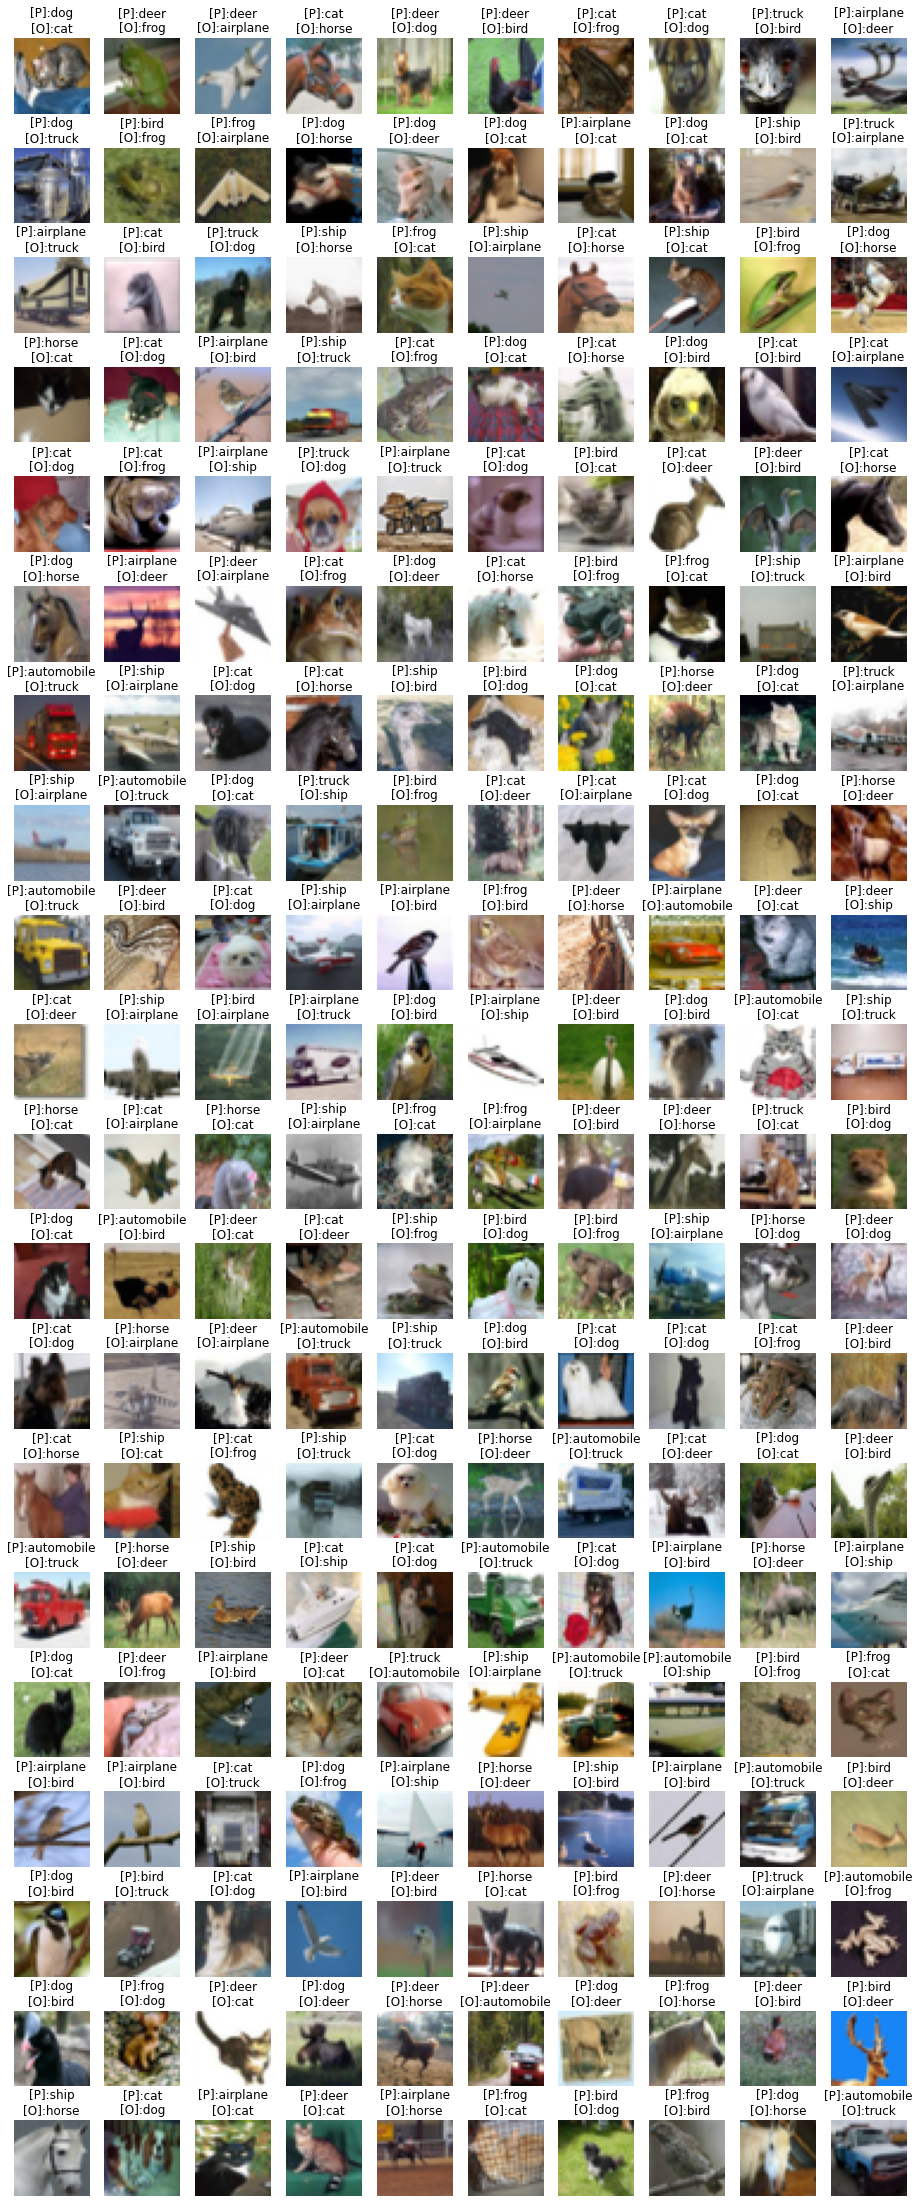

In [15]:
idx = np.nonzero(pre != y_test_1d)[0][:200] # 錯誤太多，故只查看前200張
false_pre_img = x_test[idx]
false_pre_label = y_test_1d[idx]
false_pre_predict = pre[idx]

plt.figure(figsize=(16, 42))
width = 10 
height = len(idx) // width + 1

for i, img in enumerate(false_pre_img):    
    plt.subplot(height, width, i+1)      # subplot(總高, 總寬, 第i張)
    plt.title(f"[P]:{names[false_pre_predict[i]]}\n[O]:{names[false_pre_label[i]]}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")

## 使用者上傳圖片，讓模型辨識

請輸入檔名: bird.jpg
我猜答案是: bird


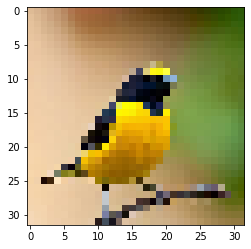

In [16]:
from tensorflow.keras.preprocessing.image import load_img

f = input("請輸入檔名: ")
img_raw = load_img(f, target_size=(32, 32))          #.convert("RGB")
img = np.array(img_raw).reshape(1, 32, 32, 3) / 255  # 注意！
answer = model.predict_classes(img)[0]
print("我猜答案是:", names[answer])
plt.imshow(img_raw)